In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
file_path = 'Total_Crops.csv'
data = pd.read_csv(file_path)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85260 entries, 0 to 85259
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mandiid          85260 non-null  int64 
 1   cropid           85260 non-null  int64 
 2   cropname         85260 non-null  object
 3   mandiname        85260 non-null  object
 4   arrivalquantity  85260 non-null  int64 
 5   maximumprice     85260 non-null  int64 
 6   minimumprice     85260 non-null  int64 
 7   modalprice       85260 non-null  int64 
 8   date             85260 non-null  object
dtypes: int64(6), object(3)
memory usage: 5.9+ MB


In [4]:
# Ensure the dataset contains 'cropid' and 'mandiid' columns
if 'cropid' in data.columns and 'mandiid' in data.columns:
    # Get the count of entries for each combination of 'cropid' and 'mandiid'
    combination_counts = data.groupby(['cropid', 'mandiid']).size().reset_index(name='count')

    # Sort the combinations by count in descending order
    combination_counts_sorted = combination_counts.sort_values(by='count', ascending=False)

    # Get the top 10 unique entries based on the counts
    top_10_unique_combinations = combination_counts_sorted.head(10)

    # Print the top 10 unique combinations without indexes
    print(top_10_unique_combinations.to_string(index=False))
else:
    print("The dataset does not contain the required 'cropid' and 'mandiid' columns.")

 cropid  mandiid  count
      7      227    986
     13      359    959
      7      981    934
      1     1122    926
      1     1129    902
      1     1142    902
      7     1331    877
      1     1235    863
     13      167    859
      1     1212    859


In [5]:
# Prompt for cropid and mandiid
cropid = int(input("Enter cropid: "))
mandiid_input = input("Enter mandiid (leave blank for all mandis): ")

Enter cropid:  7
Enter mandiid (leave blank for all mandis):  227


In [6]:
# Filter data based on inputs
if mandiid_input.strip() == "":
    filtered_data = data[data['cropid'] == cropid]
else:
    mandiid = int(mandiid_input)
    filtered_data = data[(data['cropid'] == cropid) & (data['mandiid'] == mandiid)]

In [7]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 986 entries, 55 to 85240
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mandiid          986 non-null    int64 
 1   cropid           986 non-null    int64 
 2   cropname         986 non-null    object
 3   mandiname        986 non-null    object
 4   arrivalquantity  986 non-null    int64 
 5   maximumprice     986 non-null    int64 
 6   minimumprice     986 non-null    int64 
 7   modalprice       986 non-null    int64 
 8   date             986 non-null    object
dtypes: int64(6), object(3)
memory usage: 77.0+ KB


In [8]:
# Remove outliers using Z-score method
z_scores = np.abs(stats.zscore(filtered_data['modalprice']))
filtered_data = filtered_data[z_scores < 4.8]
print(f"Data size after removing outliers: {filtered_data.shape}")

Data size after removing outliers: (984, 9)


In [9]:
# Check if filtered data is not empty
if filtered_data.empty:
    print("No data found for the given cropid and mandiid.")
else:
    cropname = filtered_data['cropname'].iloc[0]
    mandiname = filtered_data['mandiname'].iloc[0] if mandiid_input.strip() != "" else "All Mandis"

    # Prepare data for training
    dataset = filtered_data['modalprice'].values  # Assuming 'modalprice' is the target variable
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # Split into train and test sets (80% training, 20% testing)
    train_size = int(len(dataset) * 0.8)
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # Create a dataset function
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back - 1):
            a = dataset[i:(i + look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

    look_back = 5  # Increase look_back to consider more past days
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # Create and fit the LSTM network
    model = Sequential([
        Input(shape=(1, look_back)),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Add early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(trainX, trainY, epochs=200, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200
20/20 - 10s - 502ms/step - loss: 0.0615 - val_loss: 0.0279
Epoch 2/200
20/20 - 0s - 7ms/step - loss: 0.0254 - val_loss: 0.0277
Epoch 3/200
20/20 - 0s - 7ms/step - loss: 0.0243 - val_loss: 0.0261
Epoch 4/200
20/20 - 0s - 8ms/step - loss: 0.0246 - val_loss: 0.0263
Epoch 5/200
20/20 - 0s - 9ms/step - loss: 0.0245 - val_loss: 0.0269
Epoch 6/200
20/20 - 0s - 9ms/step - loss: 0.0247 - val_loss: 0.0261
Epoch 7/200
20/20 - 0s - 8ms/step - loss: 0.0241 - val_loss: 0.0270
Epoch 8/200
20/20 - 0s - 7ms/step - loss: 0.0242 - val_loss: 0.0265
Epoch 9/200
20/20 - 0s - 6ms/step - loss: 0.0241 - val_loss: 0.0267
Epoch 10/200
20/20 - 0s - 9ms/step - loss: 0.0235 - val_loss: 0.0267
Epoch 11/200
20/20 - 0s - 7ms/step - loss: 0.0243 - val_loss: 0.0263
Epoch 12/200
20/20 - 0s - 7ms/step - loss: 0.0244 - val_loss: 0.0267
Epoch 13/200
20/20 - 0s - 6ms/step - loss: 0.0241 - val_loss: 0.0273


In [10]:
# Function for generating predictions
def predict_future(model, testX, days, look_back):
    predictions = []
    current_input = testX[-1]  # Start with the last input from the test set
    current_input = np.reshape(current_input, (1, 1, look_back))
    for _ in range(days):
        prediction = model.predict(current_input)
        predictions.append(prediction[0][0])
        current_input = np.append(current_input[:, :, 1:], prediction).reshape((1, 1, look_back))
    return predictions

In [11]:
# Prompt for number of days for prediction
days = int(input("Enter number of days to predict: "))

Enter number of days to predict:  10


In [12]:
# Generate predictions for the specified number of days
predictions = predict_future(model, testX, days, look_back)

# Inverse transform the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Prepare data for visualization with fixed start date
start_date = pd.to_datetime('2024-03-04')
prediction_dates = pd.date_range(start=start_date, periods=days)
prediction_series = pd.Series(predictions.flatten(), index=prediction_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


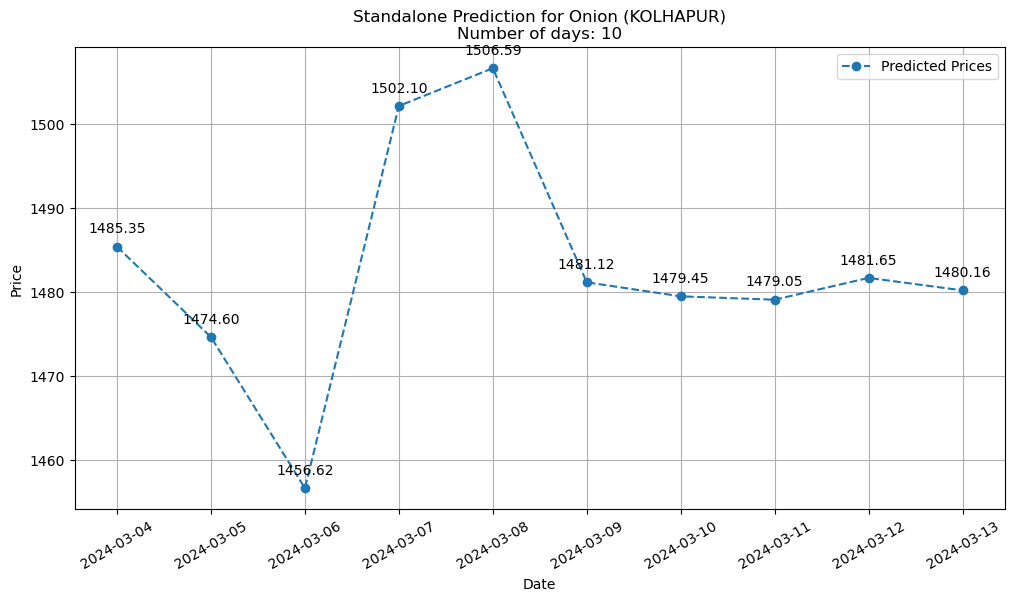

In [13]:
# Standalone prediction plot
plt.figure(figsize=(12, 6))
plt.plot(prediction_series, label='Predicted Prices', linestyle='--', marker='o')
for i, txt in enumerate(predictions):
    plt.annotate(f'{txt[0]:.2f}', (prediction_series.index[i], prediction_series.values[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title(f'Standalone Prediction for {cropname} ({mandiname})\nNumber of days: {days}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

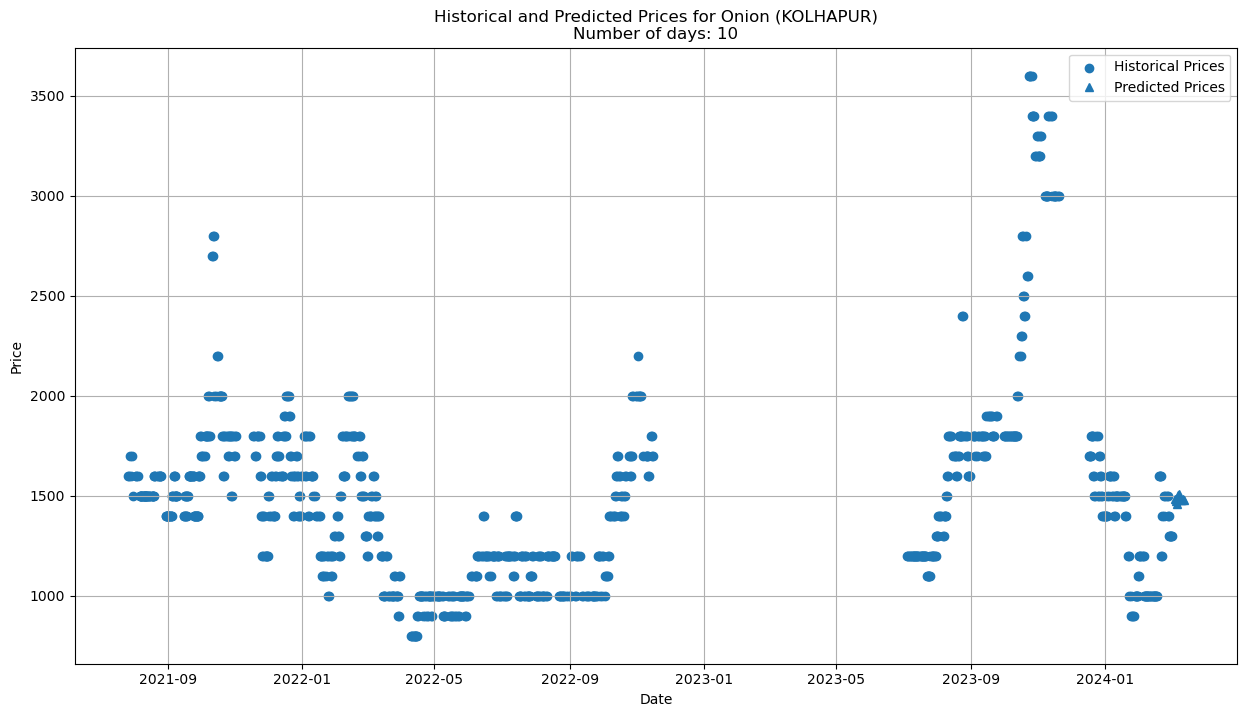

In [14]:
# Combined plot of historical data and predictions
historical_series = pd.Series(filtered_data['modalprice'].values, index=pd.to_datetime(filtered_data['date']))
plt.figure(figsize=(15, 8))
plt.scatter(historical_series.index, historical_series.values, label='Historical Prices')
plt.plot(prediction_series, label='Predicted Prices', linestyle='', marker='^')
plt.title(f'Historical and Predicted Prices for {cropname} ({mandiname})\nNumber of days: {days}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Convert predictions to a DataFrame
predicted_df = pd.DataFrame(predictions, columns=['predicted_price'])

# Save the predictions to a CSV file
output_path = f'Predicted_{cropname}_NeuralNetwork.csv'
predicted_df.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")

Predictions saved to Predicted_Onion_NeuralNetwork.csv
